# Model Tuning 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import mean_squared_error

In [2]:
pune_tmax_train = pd.read_csv(r'D:\IITM\converted_to_csv\imd5p5_tmax_train_clean.csv')
Nex_train = pd.read_csv(r'D:\IITM\prepared data\Nex_train_ready.csv')

pune_tmax_test = pd.read_csv(r'D:\IITM\converted_to_csv\imd5p5_tmax_pune_test.csv')
Nex_test = pd.read_csv(r'D:\IITM\prepared data\Nex_test_ready.csv')

#using pune tmax values as labels 
tmax_labels = pd.DataFrame(pune_tmax_train,columns=["tmax"])
tmax_labels.head() # .head() function gives out first 5 rows of the datset 

,tmax
0,28.4
1,29.4
2,29.1
3,28.3
4,28.5


In [4]:
nex_pr_train = pd.read_csv(r'D:\IITM\converted_to_csv\nex25_pr_train.csv')
nex_pr_test = pd.read_csv(r'D:\IITM\converted_to_csv\nex25_pr_test.csv')
Nex_train_final = pd.concat([Nex_train.reset_index(drop=True), nex_pr_train["precipitation"].reset_index(drop=True)],axis=1) 

In [5]:
Nex_train_final.head()

,nex_tmax,nex_tmin,nex_tmean,precipitation
0,30.1280,10.7089,20.41845,0.0
1,30.4229,10.5904,20.50665,0.0
2,30.4062,10.6063,20.50625,0.0
3,30.5158,11.8068,21.16130,0.0
4,30.4171,13.2873,21.85220,0.0


In [6]:
Nex_test_final = pd.concat([Nex_test.reset_index(drop=True), nex_pr_test["precipitation"].reset_index(drop=True)],axis=1)

In [7]:
test_labels = pd.DataFrame(pune_tmax_test,columns=["tmax"])
test_labels.head()

,tmax
0,29.7
1,30.0
2,28.2
3,28.3
4,29.6


In [8]:
Nex_test_final.head()

,nex_tmax,nex_tmin,nex_tmean,precipitation
0,30.0709,14.5580,22.31445,0.0
1,30.3630,14.8125,22.58775,0.0
2,30.2909,14.9060,22.59845,0.0
3,30.3834,14.2860,22.33470,0.0
4,30.0295,13.7385,21.88400,0.0


In [9]:
nex_test_raw = pd.read_csv(r'D:\IITM\converted_to_csv\nex25_tmax_pune_test.csv')

In [10]:
nex_test_raw.head()

,date,nex_tmax
0,01-01-2006,30.0709
1,02-01-2006,30.3630
2,03-01-2006,30.2909
3,04-01-2006,30.3834
4,05-01-2006,30.0295


In [11]:
nex_tmax = pd.DataFrame(nex_test_raw["nex_tmax"], columns=['nex_tmax'])

In [12]:
nex_tmax

,nex_tmax
0,30.0709
1,30.3630
2,30.2909
3,30.3834
4,30.0295
...,...
3645,29.3304
3646,30.7278
3647,30.7104
3648,30.2488


In [12]:
control_mse_test = mean_squared_error(test_labels, nex_tmax)
control_rmse_test = np.sqrt(control_mse_test)
print("RMSE between IMD and NEX maximum temperature data = ")
control_rmse_test

RMSE between IMD and NEX maximum temperature data = 


2.1940757830264235

### Scaling

In [13]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(Nex_train_final)
y_train = sc_y.fit_transform(tmax_labels)
X_test = sc_X.fit_transform(Nex_test_final)
y_test = sc_y.fit_transform(test_labels)

### Support Vector Regression

In [14]:
from sklearn import svm
tmax_svr = svm.SVR()
tmax_svr.fit(X_train , y_train)

c:\users\narayan\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR()

In [15]:
train_pred_svr = tmax_svr.predict(X_train)

In [16]:
train_pred_svr = sc_y.inverse_transform(train_pred_svr)

In [17]:
#calculating RMSE over train set for SVR

Nex_svr_mse_train = mean_squared_error(tmax_labels, train_pred_svr)
Nex_svr_rmse_train = np.sqrt(Nex_svr_mse_train)
print("RMSE for Support Vector Regression over train set = ")
Nex_svr_rmse_train

RMSE for Support Vector Regression over train set = 


1.5933597283805132

In [18]:
test_pred_svr = tmax_svr.predict(X_test)

In [19]:
test_pred_svr = sc_y.inverse_transform(test_pred_svr)

In [20]:
#calculating RMSE over train set for SVR
from sklearn.metrics import mean_squared_error
Nex_svr_mse_test = mean_squared_error(test_labels, test_pred_svr)
Nex_svr_rmse_test = np.sqrt(Nex_svr_mse_test)
print("RMSE for Support Vector Regression over test set = ")
Nex_svr_rmse_test

RMSE for Support Vector Regression over test set = 


1.6326791707287602

In [ ]:
test_pred_svr.to_csv(r'D:\IITM\Predictions\svr_scaled_preds.csv')

### MLP

In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit

In [22]:
parameters = {'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs'], 'max_iter': [700,800,900]}
clf = GridSearchCV(MLPRegressor(), parameters, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

c:\users\narayan\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7045561270049512
{'activation': 'tanh', 'alpha': 1e-08, 'hidden_layer_sizes': 10, 'max_iter': 700, 'solver': 'lbfgs'}


c:\users\narayan\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [25]:
mlp_reg = MLPRegressor(activation='logistic', alpha= 0.1, hidden_layer_sizes= 10, max_iter= 700, solver='lbfgs')
mlp_reg.fit(X_train, y_train)
train_preds = mlp_reg.predict(X_train)
test_preds = mlp_reg.predict(X_test)
train_pred_mlp = sc_y.inverse_transform(train_preds)
test_pred_mlp = sc_y.inverse_transform(test_preds)

mlp_reg_mse_train = mean_squared_error(test_pred_mlp, test_labels)
mlp_reg_mse_test = mean_squared_error(train_pred_mlp, tmax_labels)
mlp_reg_rmse_train = np.sqrt(mlp_reg_mse_train)
mlp_reg_rmse_test = np.sqrt(mlp_reg_mse_test)
print("RMSE of the MLP with Grid Search on trainset: ", mlp_reg_rmse_train, "\n\n")
print("RMSE of the MLP with Grid Search on testset: ", mlp_reg_rmse_test, "\n\n")

c:\users\narayan\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


RMSE of the MLP with Grid Search on trainset:  1.6363799664476235 


RMSE of the MLP with Grid Search on testset:  1.5738976274528127 




c:\users\narayan\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [28]:
mlp_reg = MLPRegressor(activation='logistic', alpha= 0.0001, hidden_layer_sizes= 10, max_iter= 700, solver='lbfgs')
mlp_reg.fit(X_train, y_train)
train_preds = mlp_reg.predict(X_train)
test_preds = mlp_reg.predict(X_test)
train_pred_mlp = sc_y.inverse_transform(train_preds)
test_pred_mlp = sc_y.inverse_transform(test_preds)

mlp_reg_mse_train = mean_squared_error(test_pred_mlp, test_labels)
mlp_reg_mse_test = mean_squared_error(train_pred_mlp, tmax_labels)
mlp_reg_rmse_train = np.sqrt(mlp_reg_mse_train)
mlp_reg_rmse_test = np.sqrt(mlp_reg_mse_test)
print("RMSE of the MLP with Grid Search on trainset: ", mlp_reg_rmse_train, "\n\n")
print("RMSE of the MLP with Grid Search on testset: ", mlp_reg_rmse_test, "\n\n")

c:\users\narayan\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


RMSE of the MLP with Grid Search on trainset:  1.6313270126078279 


RMSE of the MLP with Grid Search on testset:  1.5760448848896471 




In [26]:
pred_mlp_test = pd.DataFrame(test_pred_mlp)

In [27]:
pred_mlp_test.to_csv(r'D:\IITM\Predictions\mlp_test_preds.csv')

In [49]:
test_labels.to_csv(r'D:\IITM\Predictions\test_labels.csv')

In [51]:
mlp_test_pred = pd.read_csv(r'D:\IITM\Predictions\mlp_test_pred_withdate_01.csv')
mlp_test_pred.head()

,Date,mlp_test_preds,tmax
0,2006 JAN 01 29.7,30.363925,29.7
1,2006 JAN 02 30.0,30.472563,30.0
2,2006 JAN 03 28.2,30.471993,28.2
3,2006 JAN 04 28.3,30.385571,28.3
4,2006 JAN 05 29.6,30.228274,29.6


In [69]:
mlp_test_pred= pd.read_csv(r'D:\IITM\Predictions\mlp_test_pred_withdate_01.csv')

In [70]:
mlp_test_pred['Date'] = pd.to_datetime(mlp_test_pred['Date'])

In [71]:
mlp_test_pred

,index,Date,mlp_test_preds,nex_tmax,imd_tmax
0,1,2006-01-01,30.363925,30.0709,29.7
1,2,2006-02-01,30.472563,30.3630,30.0
2,3,2006-03-01,30.471993,30.2909,28.2
3,4,2006-04-01,30.385571,30.3834,28.3
4,5,2006-05-01,30.228274,30.0295,29.6
...,...,...,...,...,...
3645,3646,2015-12-25,30.382385,29.3304,29.4
3646,3647,2015-12-26,30.572723,30.7278,29.4
3647,3648,2015-12-27,30.518250,30.7104,30.8
3648,3649,2015-12-28,30.551383,30.2488,32.2


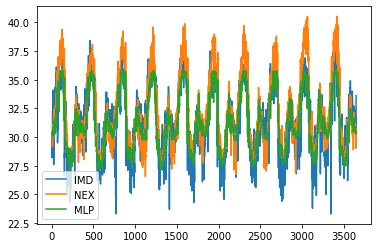

In [80]:
plt.plot(mlp_test_pred['index'], mlp_test_pred['imd_tmax'], label ="IMD")
plt.plot(mlp_test_pred['index'],mlp_test_pred['nex_tmax'], label ="NEX")
plt.plot(mlp_test_pred['index'], mlp_test_pred['mlp_test_preds'], label ="MLP")
plt.legend()

It can be clearly seen that MLP Regressor has avoided the overestimations done by the NEX25 downscaling.

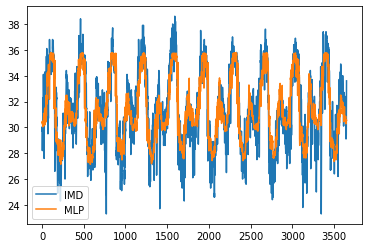

In [79]:
plt.plot(mlp_test_pred['index'], mlp_test_pred['imd_tmax'], label ="IMD")
plt.plot(mlp_test_pred['index'], mlp_test_pred['mlp_test_preds'], label ="MLP")

plt.legend()

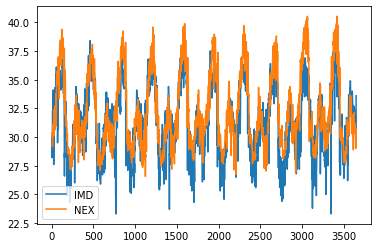

In [81]:
plt.plot(mlp_test_pred['index'], mlp_test_pred['imd_tmax'], label ="IMD")
plt.plot(mlp_test_pred['index'], mlp_test_pred['nex_tmax'], label ="NEX")

plt.legend()

### Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [30]:
lin_reg_train_preds = lin_reg.predict(X_train)
lin_reg_test_preds = lin_reg.predict(X_test)
train_pred_lr = sc_y.inverse_transform(lin_reg_train_preds)
test_pred_lr = sc_y.inverse_transform(lin_reg_test_preds)

lin_reg_mse_train = mean_squared_error(train_pred_lr, tmax_labels)
lin_reg_mse_test = mean_squared_error(test_pred_lr, test_labels)
lin_reg_rmse_train = np.sqrt(lin_reg_mse_train)
lin_reg_rmse_test = np.sqrt(lin_reg_mse_test)
print("RMSE of the Linear Regression with scaling trainset: ", lin_reg_rmse_train,"\n")
print("RMSE of the Linear Regression with scaling testset: ", lin_reg_rmse_test, "\n")

RMSE of the Linear Regression with scaling trainset:  1.723469596775698 

RMSE of the Linear Regression with scaling testset:  246118159071.60626 



### Random Forest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit

In [ ]:
estimator = RandomForestRegressor()
param_grid = { 
            "n_estimators"      : [400, 500, 600, 700, 800],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

grid.fit(X_train, y_train)
return grid.best_score_ , grid.best_params_